# FBP reconstruction of the agarose phantom


In [1]:
# Import relevant packages

from __future__ import division
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
import numpy as np
from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt

# Timing
from tqdm import tqdm
import time

# Garbage collection
import gc

import sys
sys.path.append('../')

Code starts here

Reconstruction of our image from 2D geometry

In [3]:
# Regular import
# del im
# del reconstruction_fbp
gc.collect()

import pickle
with open("2023-04-10 agarose-phantom-fourier-bgdivide-imag-addmin.pkl", 'rb') as f:
    im = pickle.load(f)

In [7]:
with open("2023-04-10 agarose-phantom-fourier-firstproj.pkl", 'wb') as f:
    pickle.dump(im[0], f)

In [10]:
# Crop image to centre the centre of the image on the rotation axis
# im has dimensions (projections, height, width)
# The crop is 12
im = im[:,::100,12:]
im.shape

(400, 14, 1028)

In [11]:
im.shape

(400, 14, 1028)

In [12]:
im.min(), im.max()

(-0.0, 0.029061591703793965)

In [13]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

# Preallocate Memory
reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

(14, 400, 1028)


Phase can be positive or negative. We do not rescale and do not limit our reconstructions but instead use floating point representation throughout.

In [14]:
### Configuration ##################################
output_dir = 'test_recon' # Directory to save reconstructions to
maximum_value =  65535 # Value to scale the data to. Default is 65535. 
save_reconstruction = False

# Infer parameters from inputs
num_of_projections = im.shape[1]
detector_rows = im.shape[0]  # Vertical size of detector [pixels].
detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)

start = time.time()
for i in tqdm(range(im.shape[0])):
    # Copy projection images into ASTRA Toolbox.
    proj_geom = \
      astra.create_proj_geom('parallel', 1.0, detector_cols, angles)
    projections_id = astra.data2d.create('-sino', proj_geom, im[i])

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                              detector_rows)
    reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('FBP_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(reconstruction_id)

    # Limit and scale reconstruction.
    # reconstruction[reconstruction < 0] = 0
    # reconstruction /= maximum_value
    # reconstruction = np.round(reconstruction * 65535).astype(np.uint16)

    # Save reconstruction.
    if save_reconstruction: 
        if not isdir(output_dir):
            mkdir(output_dir)
        #for i in range(detector_rows):
            #im = reconstruction[i, :, :]
            #im = np.flipud(im)
        imsave(join(output_dir, 'reco%04d.tif' % i), reconstruction)
    
    # Save reconstruction to preallocated memory
    reconstruction_fbp[i] = reconstruction
    
    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data2d.delete(reconstruction_id)
    astra.data2d.delete(projections_id)

end = time.time()
print(end-start)

#plt.imshow(reconstruction)

100%|██████████| 14/14 [00:01<00:00,  7.73it/s]

2.049722909927368


In [11]:
np.max(reconstruction_fbp)

9.531224350212142e-05

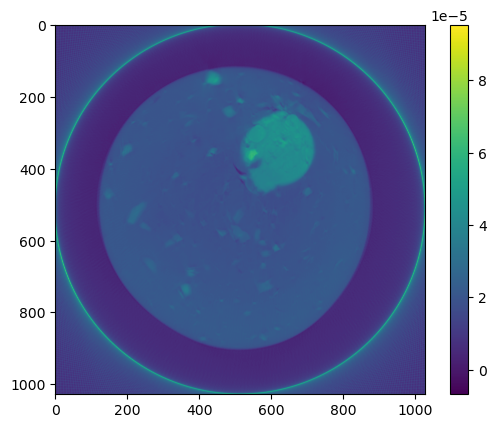

In [12]:
plt.imshow(reconstruction_fbp[-1], vmin=np.min(reconstruction_fbp), vmax=np.max(reconstruction_fbp)) #696
plt.colorbar()

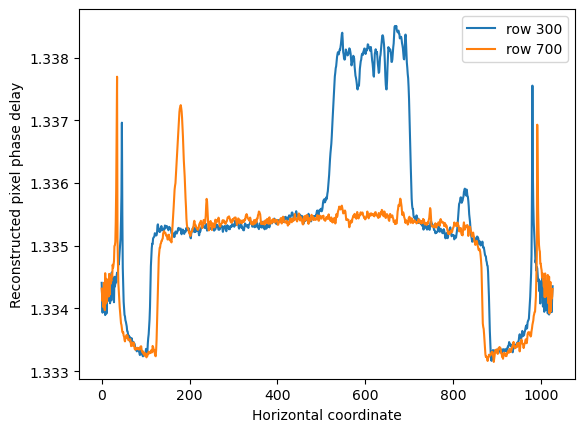

In [25]:

plt.plot(reconstruction_fbp[10, 300]*100 + 1.333, label='row 300')
plt.plot(reconstruction_fbp[10, 700]*100 + 1.333, label='row 700')
plt.ylabel('Reconstructed pixel phase delay')
plt.xlabel('Horizontal coordinate')
plt.legend()

In [15]:
with open("2023-04-10 agarose-phantom-fourier-14slices.pkl", 'wb') as f:
    pickle.dump(reconstruction_fbp, f)